

- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Imports


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from xgboost import XGBClassifier


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# hierarquical
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.metrics import (h_fbeta_score,
                                                         h_precision_score, 
                                                         h_recall_score)

# creating hierarchy
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm_notebook


In [2]:
TESTING = False
BASE_MODEL = DecisionTreeClassifier
RANDOM_STATE = 42
N_SIMUL = 50



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Helper functions


The following function was original found in the sklearn-hierarcical-classification libray; 
Unfortunately, due to a bug, it can't compile properly - we therefore include it here as taken from the source code.

In [3]:
from contextlib import contextmanager

import numpy as np
from networkx import all_pairs_shortest_path_length, relabel_nodes
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn_hierarchical_classification.constants import ROOT

@contextmanager
def multi_labeled(y_true, y_pred, graph):
    """
    Helper context manager for using the hierarchical evaluation metrics
    defined in this model.
    Briefly, the evaluation metrics expect data in a binarized multi-label format,
    the same as returned when using scikit-learn's MultiLabelBinarizer.
    This method therefore encapsulate the boilerplate required to fit such a
    label transformation on the data we wish to evaluate (y_true, y_pred) as well as
    applying it to the class hierarchy itself (graph), by relabeling the nodes.
    See the examples/classify_digits.py file for example usage.
    Parameters
    ----------
    y_true : array-like, shape = [n_samples, 1].
        ground truth targets
    y_pred : array-like, shape = [n_samples, 1].
        predicted targets
    graph : the class hierarchy graph, given as a `networkx.DiGraph` instance
    Returns
    -------
    y_true_ : array-like, shape = [n_samples, n_classes].
        ground truth targets, transformed to a binary multi-label matrix format.
    y_pred_ : array-like, shape = [n_samples, n_classes].
        predicted targets, transformed to a binary multi-label matrix format.
    graph_ : the class hierarchy graph, given as a `networkx.DiGraph` instance,
        transformed to use the (integer) IDs fitted by the multi label binarizer.
    """
    mlb = MultiLabelBinarizer()
    all_classes = [
        node
        for node in graph.nodes
        if node != ROOT
    ]
    # Nb. we pass a (singleton) list-within-a-list as fit() expects an iterable of iterables
    mlb.fit([all_classes])

    node_label_mapping = {
        old_label: new_label
        for new_label, old_label in enumerate(list(mlb.classes_))
    }

    yield (
        mlb.transform(y_true),
        mlb.transform(y_pred),
        relabel_nodes(graph, node_label_mapping),
)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Create experiment

In [4]:
df = pd.read_csv("data/instruments.csv")
df["class"] = df["class"].str.replace("-", "")

encoding = LabelEncoder()
last_classes = df["class"].str.split(".").apply(lambda x: x[-1]).unique()
encoding.fit(last_classes)

if TESTING:
    #df = df.sample(frac=0.3)
    N_SIMUL = 10    
    
all_results = pd.DataFrame(columns=["h_fbeta", "h_precision", "h_recall", "model"])

In [5]:
df["class"].unique()

array(['Instrument.Aerophone.Wood.Clarinet',
       'Instrument.Aerophone.Wood.Flute',
       'Instrument.Aerophone.Wood.Oboe',
       'Instrument.Aerophone.Brass.Trombone',
       'Instrument.Aerophone.Brass.Tuba',
       'Instrument.Aerophone.Wood.Saxophone',
       'Instrument.Aerophone.Wood.Bassoon',
       'Instrument.Aerophone.Brass.Horn',
       'Instrument.Aerophone.Brass.Trumpet'], dtype=object)

In [6]:
options = [x.split(".")[1:] for x in df["class"].unique()]
mosquitos_hierarchy = defaultdict(set)

for class_ in options:
    for previous, current in zip([ROOT]+class_, class_):
        if current in last_classes:
            class_num = encoding.transform([current])[0]
            mosquitos_hierarchy[previous].add(f"{class_num}")
        else:
            mosquitos_hierarchy[previous].add(current)

for key in mosquitos_hierarchy.keys():
    mosquitos_hierarchy[key] = list(mosquitos_hierarchy[key])

mosquitos_hierarchy = dict(mosquitos_hierarchy)

pprint(mosquitos_hierarchy)

{-1: ['Aerophone'],
 'Aerophone': ['Wood', 'Brass'],
 'Brass': ['3', '8', '7', '6'],
 'Wood': ['0', '4', '1', '5', '2']}


![Hierarquia mosquitos](../images/instruments.png)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [7]:
def run_experiment(df, class_hierarchy, encoding, clf, random_state=RANDOM_STATE):
    X = df.drop(columns="class")
    y = encoding.transform(df["class"].str.split(".").apply(lambda x: x[-1]))
    y = y.astype(str)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=random_state,
                                                       stratify=y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    if TESTING:
        target_names = encoding.inverse_transform(np.sort(np.unique(y)).astype(int))
        print("Classification Report:\n", 
              classification_report(y_test, y_pred, target_names=target_names))
        
    # Demonstrate using our hierarchical metrics module with MLB wrapper
    try:
        my_graph = clf.graph_
    except:
        from networkx import DiGraph
        my_graph = DiGraph(class_hierarchy)
        
    with multi_labeled(y_test, y_pred, my_graph) as (y_test_, y_pred_, graph_):
        results = {
            "h_fbeta": h_fbeta_score(y_test_, y_pred_, graph_),
            "h_precision": h_precision_score(y_test_, y_pred_, graph_),
            "h_recall": h_recall_score(y_test_, y_pred_, graph_),
        }
    return results

In [8]:
def print_results(results):
    for key, item in results.items():
        print(f"Result for {key}: {item}")

# A better way to evaluate

Let's actually use the hierarchical data

[Functional Annotation of Genes Using Hierarchical Text Categorization](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.5824&rep=rep1&type=pdf)

## Hierarchical Precision and Recall

![](hierarchical_metrics.png)

## Hierarchical F1 score

The common way of calculating F1 is:
![](f1_normal.png)

The proposed hierarchical version is:
![](f1_hierarchical.png)

With beta = 1, we give equal weights to both precision and recall



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Models

## Flat

In [9]:
%%time
for i in tqdm_notebook(range(N_SIMUL)):
    rdm_state = RANDOM_STATE + i
    clf = BASE_MODEL(random_state=rdm_state)
    results = run_experiment(df, mosquitos_hierarchy, encoding, 
                             clf, random_state=rdm_state)
    
    all_results.loc[len(all_results), :] = list(results.values()) + ["flat"]

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 


CPU times: user 11.5 s, sys: 72.3 ms, total: 11.6 s
Wall time: 11.5 s


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Top Down

### 1 multiclass classifier per Node

In [10]:
%%time
for i in tqdm_notebook(range(N_SIMUL)):
    rdm_state = RANDOM_STATE + i
    clf = HierarchicalClassifier(base_estimator=BASE_MODEL(), 
                             class_hierarchy=mosquitos_hierarchy, 
                             prediction_depth="mlnp",
                             algorithm="lcpn",
                            )   
    results = run_experiment(df, mosquitos_hierarchy, encoding, 
                             clf, random_state=rdm_state)
    all_results.loc[len(all_results), :] = list(results.values()) + ["1 per node"]

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 


CPU times: user 1min 28s, sys: 1.3 s, total: 1min 30s
Wall time: 1min 29s


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Results

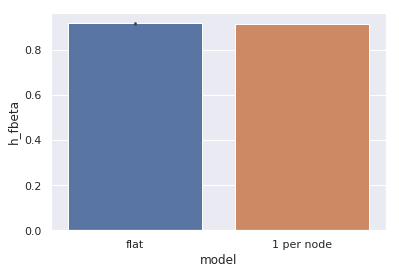

In [11]:
sns.barplot(data=all_results, y="h_fbeta", x="model")#, hue="Ruido %")

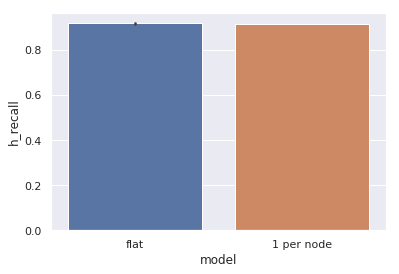

In [12]:
sns.barplot(data=all_results, y="h_recall", x="model")

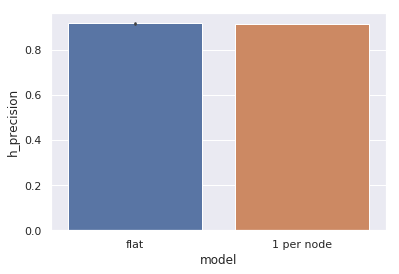

In [13]:
sns.barplot(data=all_results, y="h_precision", x="model")

In [16]:
for model in ["flat", "1 per node"]:
    model_results = all_results.query("model == @model")
    print(f"For model {model}, we obtained ", 
          f"{model_results.h_fbeta.mean()} h_fbeta +-",
          f"{model_results.h_fbeta.std()}")
    
    print(f"For model {model}, we obtained ", 
          f"{model_results.h_precision.mean()} precision +-",
          f"{model_results.h_precision.std()}")
    
    print(f"For model {model}, we obtained ", 
          f"{model_results.h_recall.mean()} recall +-",
          f"{model_results.h_recall.std()}")

For model flat, we obtained  0.9176894173824693 h_fbeta +- 0.0036177535500840734
For model flat, we obtained  0.9170325930328224 precision +- 0.0038519415600701498
For model flat, we obtained  0.9183490378234902 recall +- 0.003615341054648497
For model 1 per node, we obtained  0.9145464067652405 h_fbeta +- 0.004441589295421677
For model 1 per node, we obtained  0.9140225489320235 precision +- 0.004480875870913221
For model 1 per node, we obtained  0.9150736562707367 recall +- 0.004687690963088736


In [15]:
all_results

,h_fbeta,h_precision,h_recall,model
0,0.909163,0.90778,0.910551,flat
1,0.92322,0.923281,0.923159,flat
2,0.921344,0.920064,0.922628,flat
3,0.916899,0.915685,0.918115,flat
4,0.917209,0.91843,0.915992,flat
5,0.921943,0.922188,0.921699,flat
6,0.91686,0.915344,0.918381,flat
7,0.909586,0.909948,0.909224,flat
8,0.914892,0.914589,0.915196,flat
9,0.912594,0.910665,0.914532,flat
